# 12-lead ECG disease prediction

## Loading data

In [1]:
# !python -V > full_requirements.txt && pip list --format=freeze >> full_requirements.txt

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import joblib
from pathlib import Path
%matplotlib inline

# Import custom modules
from src.data_processing import load_processed_data


Functions

In [3]:
def classify_cardiac_condition(diagnosis_codes):
    # Normal codes
    normal_codes = ['426783006']  # Normal sinus rhythm

    # Rhythm disorder codes (arrhythmias)
    arrhythmia_codes = [
        '49436004',   # AF
        '164889003',  # Atrial flutter
        '427172004',  # PVC
        '426761007',  # VT
        '284470004',  # PAC
        '164896001',  # VF
        '195126007',  # AT
        '251146004',  # Sinus tachycardia
        '427393009'   # Sinus bradycardia
    ]

    # Conduction disease codes
    conduction_codes = [
        '59118001',   # RBBB
        '28189009',   # LBBB
        '270492004',  # 1st degree AVB
        '445211001',  # 2nd degree AVB
        '27885002'    # Complete heart block
    ]
    
    # Structural/Ischemic codes
    structural_codes = [
        '22298006',   # MI
        '164865005',  # ST elevation
        '164867002',  # ST depression
        '164873001',  # LVH
        '164874007'   # RVH
    ]
    
    if any(code in diagnosis_codes for code in normal_codes):
        return 'Normal'
    elif any(code in diagnosis_codes for code in arrhythmia_codes):
        return 'Arrhythmia'
    elif any(code in diagnosis_codes for code in conduction_codes):
        return 'Conduction'
    elif any(code in diagnosis_codes for code in structural_codes):
        return 'Structural'
    else:
        return 'Other'

Only Execute first time (to define index split)

In [4]:
# # Try loading preprocessed data
# data_path = '/Users/marcpalomer/Documents/Personal/ECG_prediction/Results/processed_data'
# try:
#    ecg_data, patient_data = load_processed_data(data_path)
#    print(f"Loaded data for {len(ecg_data)} patients")
# except (FileNotFoundError, StopIteration):
#    raise FileNotFoundError("Preprocessed data not found. Please run data_processing.py first")


# # Define stratification based on diagnosis
# patient_data['diagnosis_class'] = patient_data['diagnosis_code'].apply(classify_cardiac_condition)

# # Create development and validation sets (70/30 split)
# dev_indices, val_indices = train_test_split(
#     patient_data.index,
#     test_size=0.7,
#     random_state=42,
#     stratify=patient_data['diagnosis_class']
# )

# del ecg_data
# del patient_data

# # Save indices for reproducibility
# np.save('/Results/dev_indices.npy', dev_indices)
# np.save('/Results/val_indices.npy', val_indices)

 ## 2. Initial Data Split

In [5]:
# Load validation indices
dev_indices = np.load('./Results/dev_indices.npy', allow_pickle=True)
val_indices = np.load('./Results/val_indices.npy', allow_pickle=True)


In [6]:
data_path = '/Users/marcpalomer/Documents/Personal/ECG_prediction/Results/processed_data'
try:
   dev_ecg_dict, dev_data = load_processed_data(data_path, indices= dev_indices)
   print(f"Loaded data for {len(dev_data)} patients")
except (FileNotFoundError, StopIteration):
   raise FileNotFoundError("Preprocessed data not found. Please run data_processing.py first")

dev_ecg = {k: v['ecg_signals_filtered'] for k, v in dev_ecg_dict.items()}
del dev_ecg_dict

print("Development set size:", len(dev_indices))
print("Validation set size:", len(val_indices))



Using 7 CPUs for parallel processing
Loading data from: /Users/marcpalomer/Documents/Personal/ECG_prediction/Results/processed_data/processed_20250115_132555


Loading patient data: 100%|██████████| 13545/13545 [00:28<00:00, 473.13patient/s]


Successfully loaded 13545 out of 13545 patients from /Users/marcpalomer/Documents/Personal/ECG_prediction/Results/processed_data/processed_20250115_132555
2025-01-22 23:56:15 - load_processed_data took 0.55 minutes
Loaded data for 13545 patients
Development set size: 13545
Validation set size: 31606


In [7]:
dev_ecg['JS39860'].head()

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,24.757664,39.755189,14.924248,-32.515168,5.269304,27.581105,-15.811656,-27.035558,37.316537,65.390559,55.576675,40.087709
1,37.146640,37.483773,-1.217461,-37.987494,17.468575,15.823553,-20.632514,-39.980575,35.603100,64.931171,65.830494,38.046288
2,33.877790,29.702617,-5.343235,-32.719585,18.493337,10.215643,-28.578710,-46.279998,28.099050,59.473712,63.660321,32.931304
3,28.567011,25.834693,-3.055691,-27.341277,16.654305,10.822514,-32.740559,-45.939812,23.480422,56.502058,59.679003,32.923527
4,37.707705,32.644687,-5.522876,-34.298418,22.519552,13.036560,-29.432669,-45.991551,24.137263,58.610878,63.219245,38.319418


In [8]:
dev_data.head()

,age,sex,diagnosis_code,diagnosis_name
JS00067,77.0,Male,"['164889003', '55827005', '428750005']","['Atrial Fibrillation', 'Left Ventricular Hype..."
JS00104,68.0,Male,['426177001'],['Sinus Bradycardia']
JS00058,63.0,Female,['426783006'],['Sinus Rhythm (Normal)']
JS00059,39.0,Female,"['427084000', '428750005']","['Sinus Tachycardia', 'ST-T Change']"
JS00065,60.0,Male,['426177001'],['Sinus Bradycardia']


## Illness distribution and filtering

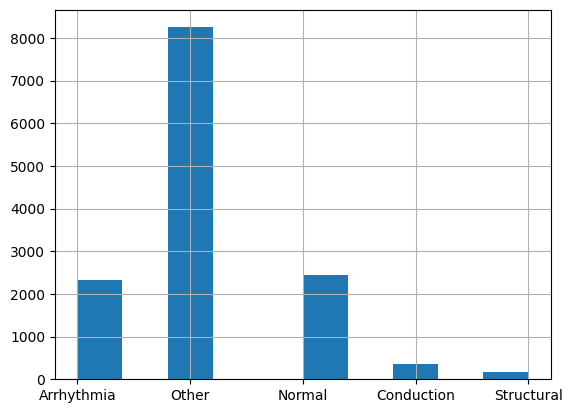

In [9]:
# Apply to dataframe
dev_data['cardiac_condition'] = dev_data['diagnosis_code'].apply(classify_cardiac_condition)
dev_data['cardiac_condition'].hist()
plt.show()

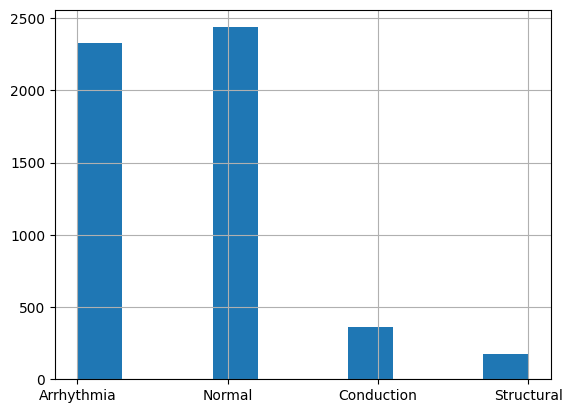

In [10]:
# First filter patient_data
dev_data_filtered = dev_data[dev_data['cardiac_condition'] != 'Other']
dev_data_filtered['cardiac_condition'].hist()
plt.show()

In [11]:
# Then filter ecg_data to only keep patients in the filtered patient_data
dev_ecg_filtered = {
    patient_id: data 
    for patient_id, data in dev_ecg.items() 
    if patient_id in dev_data_filtered.index
}

print(f"Original ECG records: {len(dev_ecg)}")
print(f"Filtered ECG records: {len(dev_ecg_filtered)}")

Original ECG records: 13545
Filtered ECG records: 5297


### HRV calculation in lead II (gold standard) (it is a time saries for patient so like a new lead...)

In [12]:
import neurokit2 as nk
import numpy as np

def validate_rpeaks(rpeaks, fs):
    # Remove physiologically impossible R-peaks
    rr_intervals = np.diff(rpeaks) / fs
    valid_rr = (rr_intervals >= 0.2) & (rr_intervals <= 2.0)  
    valid_peaks = rpeaks[1:][valid_rr]
    return valid_peaks

def calculate_hr_metrics(rpeaks, fs):
    rr_intervals = np.diff(rpeaks) / fs
    hr = 60 / rr_intervals
    return np.median(hr), np.mean(hr), np.std(hr), np.min(hr), np.max(hr)

def calculate_heartrate(record, fs):
    # Find R-peaks using neurokit2
    rpeaks = list(nk.ecg_findpeaks(record, sampling_rate=fs).values())[0]
    rpeaks = validate_rpeaks(rpeaks, fs)
    return calculate_hr_metrics(rpeaks, fs)

def add_hr_metrics(patient_data, ecg_data):
    metrics = {'median_hr': [], 'mean_hr': [], 'std_hr': [], 'min_hr': [], 'max_hr': []}
    
    for id in patient_data.index:
        if id in ecg_data:
            lead_II = ecg_data[id].loc[:,'II']
            try:
                median_hr, mean_hr, std_hr, min_hr, max_hr = calculate_heartrate(lead_II, fs=500)
            except:
                median_hr, mean_hr, std_hr, min_hr, max_hr = [np.nan,np.nan,np.nan,np.nan,np.nan]
            metrics['median_hr'].append(median_hr)
            metrics['mean_hr'].append(mean_hr)
            metrics['std_hr'].append(std_hr)
            metrics['min_hr'].append(min_hr)
            metrics['max_hr'].append(max_hr)
        else:
            for key in metrics:
                metrics[key].append(None)
    
    for metric, values in metrics.items():
        patient_data[metric] = values
    
    return patient_data

dev_hrv = add_hr_metrics(dev_data_filtered, dev_ecg_filtered)
dev_hrv.head()

,age,sex,diagnosis_code,diagnosis_name,cardiac_condition,median_hr,mean_hr,std_hr,min_hr,max_hr
JS00067,77.0,Male,"['164889003', '55827005', '428750005']","['Atrial Fibrillation', 'Left Ventricular Hype...",Arrhythmia,88.121118,98.571389,26.673713,60.240964,145.631068
JS00058,63.0,Female,['426783006'],['Sinus Rhythm (Normal)'],Normal,79.904951,80.028663,2.000351,77.519380,82.644628
JS00071,76.0,Female,"['164889003', '698252002', '55827005', '428750...","['Atrial Fibrillation', Snomed_CT\n698252002 ...",Arrhythmia,93.314628,106.268614,29.310936,65.789474,147.783251
JS00074,84.0,Male,"['164889003', '39732003', '164934002', '173380...","['Atrial Fibrillation', 'Axis left shift', 'T ...",Arrhythmia,100.334448,97.860989,20.401339,71.090047,140.186916
JS00036,74.0,Female,['164889003'],['Atrial Fibrillation'],Arrhythmia,91.139591,96.658592,21.621066,66.371681,131.578947


# ML Classifier

In [13]:
analyse_features= ['median_hr',	'mean_hr','std_hr',	'min_hr', 'max_hr', 'age']
ML_dataset = dev_hrv[analyse_features+['cardiac_condition']]
# arrythmia_ml_dataset = ML_dataset[ML_dataset['cardiac_condition'].isin(['Normal','Arrhythmia'])]
ML_dataset.value_counts('cardiac_condition')

cardiac_condition
Normal        2437
Arrhythmia    2327
Conduction     359
Structural     174
Name: count, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split
import src.RF_pipeline as RF_pipeline

def prepare_data(df, target_col, features=None, test_size=0.2, random_state=42):
    """Main function to analyze the model."""
    if features is None:
        features = [col for col in df.columns if col != target_col]
    
    X = df[features]
    y = df[target_col]

    analyzer = RF_pipeline.RandomForestAnalyzer()
    visualizer = RF_pipeline.ModelVisualizer()
    # Preprocess data
    X_processed, y_processed, y_mapping = analyzer.preprocess(X,y)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=test_size, random_state=random_state)
    


    return X_train, X_test, y_train, y_test, y_mapping, analyzer, visualizer, features
   
X_train, X_test, y_train, y_test, y_mapping, analyzer, visualizer, features = prepare_data(df=ML_dataset, target_col='cardiac_condition', features=None)

## Cross validated performance

2025-01-22 23:56:18 - cross_validate took 0.03 minutes


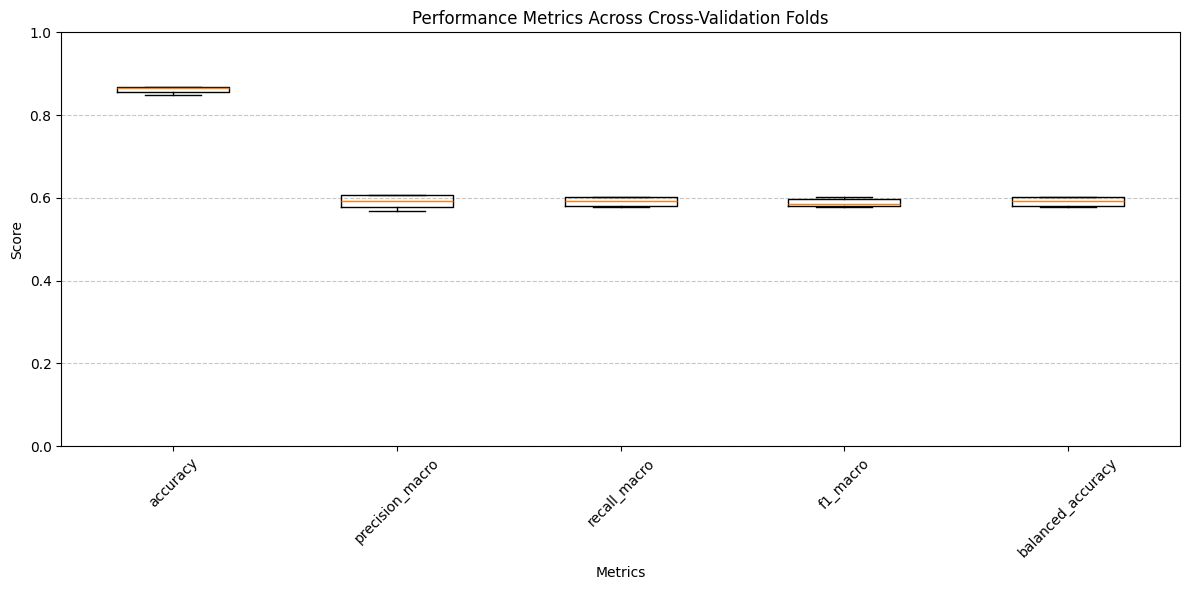

,Metric,Mean,Std
0,test_accuracy,0.8608,0.0081
1,test_precision_macro,0.5909,0.0150
2,test_recall_macro,0.5910,0.0105
3,test_f1_macro,0.5888,0.0095
4,test_balanced_accuracy,0.5910,0.0105


In [15]:
# Perform cross-validation
cv_results = analyzer.cross_validate(X_train, y_train)

# Visualize cross-validation results
visualizer.plot_cv_results(scores=cv_results, multiclass=True)

# Optional: Print detailed metrics

metrics = ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_balanced_accuracy']
stats = ['Mean', 'Std']

# Create empty lists to store values
means = [np.mean(cv_results[metric]) for metric in metrics]
stds = [np.std(cv_results[metric]) for metric in metrics]

# Create the dataframe
df = pd.DataFrame({
    'Metric': metrics,
    'Mean': means,
    'Std': stds
})
# Optional: Round the values to 4 decimal places
df[['Mean', 'Std']] = df[['Mean', 'Std']].round(4)

# Display the dataframe
df

In [16]:
y_mapping

{0: 'Arrhythmia', 1: 'Conduction', 2: 'Normal', 3: 'Structural'}

2025-01-22 23:56:19 - get_fitted_model took 0.00 minutes


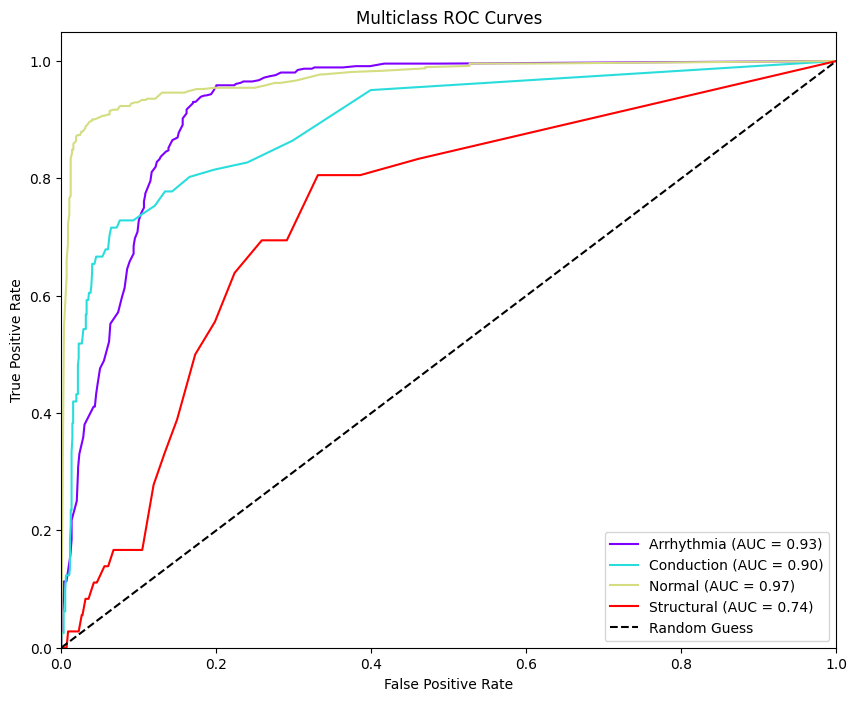


Class-wise AUC:
Arrhythmia: 0.9257
Conduction: 0.8953
Normal: 0.9715
Structural: 0.7395


In [17]:
# Train the model
rf_model = analyzer.get_fitted_model(X_train, y_train)

# Predict probabilities on test set
y_pred_proba = rf_model.predict_proba(X_test)

# Get class names from encoding dictionary
classes = list(y_mapping.values())

# Plot multiclass ROC curves
roc_auc = visualizer.plot_multiclass_roc(y_test, y_pred_proba, classes)

# Print AUC for each class
print("\nClass-wise AUC:")
for cls, auc_val in zip(classes, roc_auc.values()):
    print(f"{cls}: {auc_val:.4f}")

## Decision boundary display

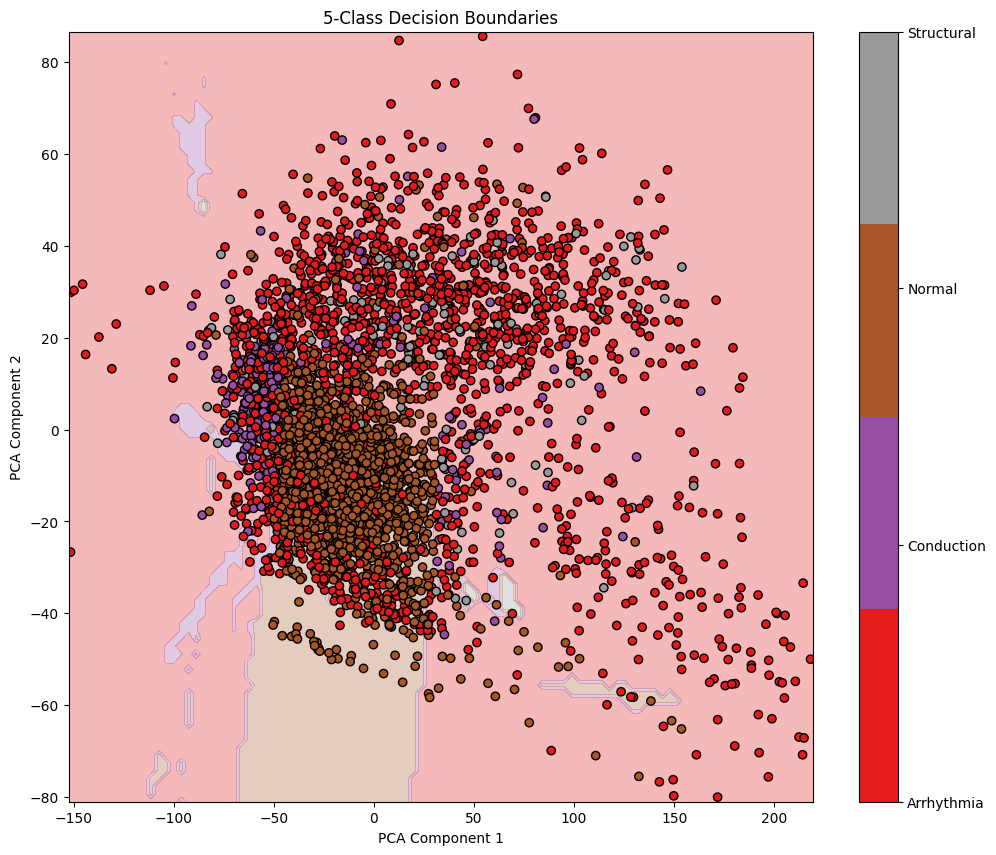

In [18]:
from sklearn.decomposition import PCA

def plot_5class_decision_space(X, y, model, class_names):
    # PCA reduction
    reducer = PCA(n_components=2)
    X_reduced = reducer.fit_transform(X)
    
    # Create mesh grid
    x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
    y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )
    
    # Reconstruct original feature space
    grid_reduced = np.c_[xx.ravel(), yy.ravel()]
    grid_original = reducer.inverse_transform(grid_reduced)
    
    # Predict classes for mesh grid
    Z = model.predict(grid_original).reshape(xx.shape)
    
    plt.figure(figsize=(12, 10))
    
    # Use discrete colormap for categorical data
    cmap = plt.cm.get_cmap('Set1', len(class_names))
    
    # Plot decision regions with discrete colors
    plt.contourf(xx, yy, Z, levels=len(class_names)-1, 
                 cmap=cmap, alpha=0.3)
    
    # Scatter plot of original points
    scatter = plt.scatter(
        X_reduced[:, 0], 
        X_reduced[:, 1], 
        c=y, 
        cmap=cmap,
        edgecolor='black'
    )
    
    # Create colorbar with actual class names
    cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
    cbar.set_ticklabels(class_names)
    
    plt.title('5-Class Decision Boundaries')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()
    
    return X_reduced

# Usage example
class_names = list(y_mapping.values())
X_pca = plot_5class_decision_space(X_train, y_train, model=rf_model, class_names=class_names)

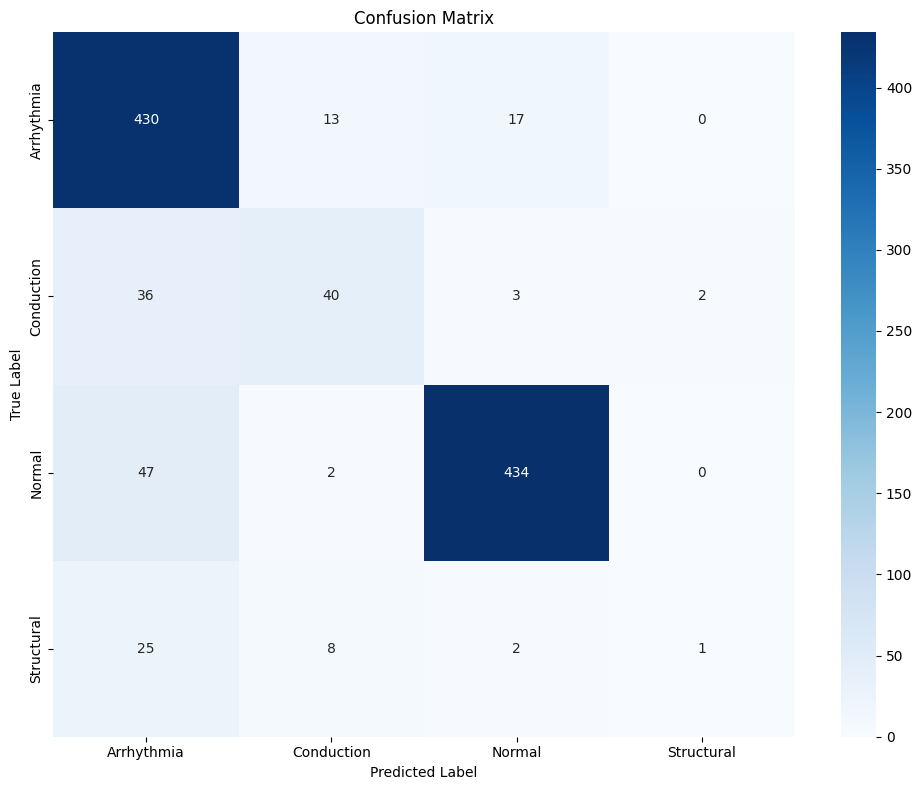

              precision    recall  f1-score   support

  Arrhythmia       0.80      0.93      0.86       460
  Conduction       0.63      0.49      0.56        81
      Normal       0.95      0.90      0.92       483
  Structural       0.33      0.03      0.05        36

    accuracy                           0.85      1060
   macro avg       0.68      0.59      0.60      1060
weighted avg       0.84      0.85      0.84      1060



In [19]:
y_pred = rf_model.predict(X_test)
visualizer.plot_multiclass_confusion_matrix(y_test, y_pred, list(y_mapping.values()))

## Shap values (Discarded section): 

## Train final ML dataset

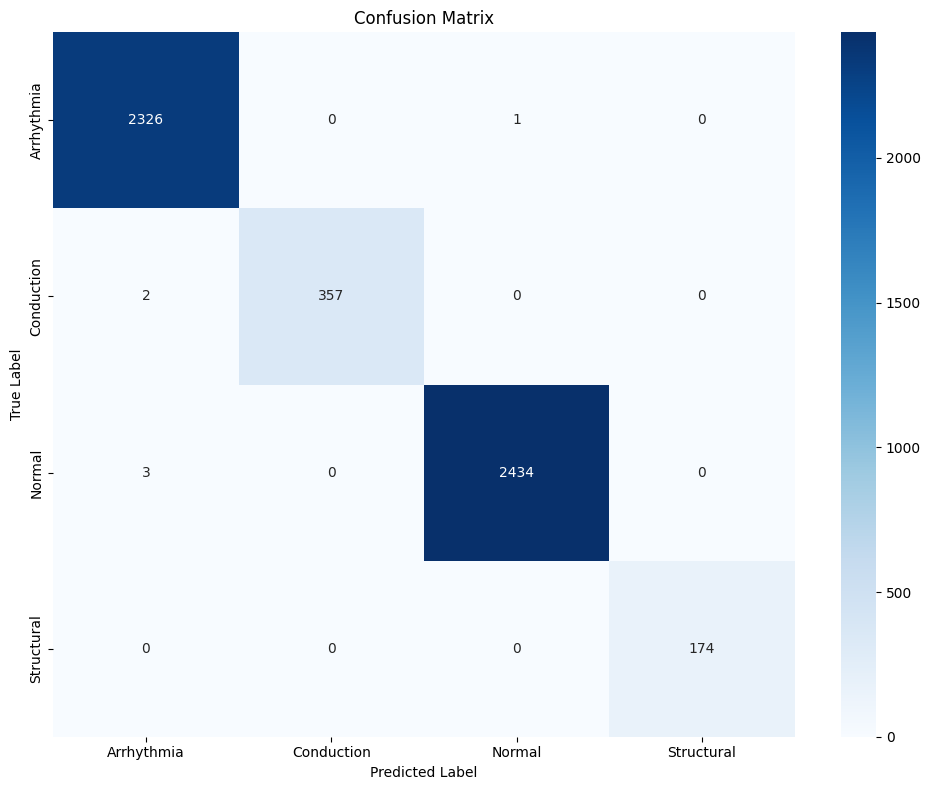

              precision    recall  f1-score   support

  Arrhythmia       1.00      1.00      1.00      2327
  Conduction       1.00      0.99      1.00       359
      Normal       1.00      1.00      1.00      2437
  Structural       1.00      1.00      1.00       174

    accuracy                           1.00      5297
   macro avg       1.00      1.00      1.00      5297
weighted avg       1.00      1.00      1.00      5297



In [20]:
# Prepare full training data
X_full_train = pd.concat([X_train, X_test])
y_full_train = np.concatenate([y_train, y_test])

# Train final model
final_model = RF_pipeline.RandomForestClassifier(
    n_estimators=100, 
    random_state=42
)
final_model.fit(X_full_train, y_full_train)

# Optional: Save the model
joblib.dump(final_model, './Results/final_ml_model.joblib')

# Verify model performance
y_pred = final_model.predict(X_full_train)
visualizer.plot_multiclass_confusion_matrix(y_full_train, y_pred, list(y_mapping.values()))

## Save final model

In [21]:
# After training
analyzer = RF_pipeline.RandomForestAnalyzer()
analyzer.save_model(final_model, X_full_train)

Model saved in: Results/RF_model/results_20250122_235620


'Results/RF_model/results_20250122_235620'

# DL CNN prediction: 
- Will we beat HRV RF classification?

### Training Phase
1. **Data Preparation**
  - Raw ECG dictionary + labels → `prepare_data()` → `normalize_signals()`
  - Train/val/test split
  - Dataset & DataLoader creation for batching

2. **Training Cycle**
  - DataLoader feeds batches to ModelTrainer
  - Forward pass through ECGNet
  - Loss calculation, backpropagation
  - Validation performance check
  - Save best model
  - Track metrics history

### Evaluation Phase
1. **Model Assessment**
  - Load best model weights
  - Full forward pass on test set
  - Generate predictions/probabilities

2. **Results**
  - Performance metrics calculation
  - Visualization generation
  - Save all results

## DL Architecture

### Input Processing
- 12-lead ECG signals
- 5000 timepoints per lead
- Normalized per lead

### Feature Extraction
- Conv1d (k=50): QRS complex detection
- Conv1d (k=7): Wave morphology
- Conv1d (k=5): Fine details
- Increasing channels (12→32→64→128) for feature hierarchy

### Each Conv Block
- BatchNorm: Training stability
- ReLU: Non-linearity
- MaxPool: Dimension reduction

### Classification
- AdaptivePool: Fixed output size
- FC layers (6400→256→64→2)
- Dropout layers prevent overfitting
- Output: Binary classification probabilities

## Label encoding

In [22]:
# Prepare your labels
dev_labels_filtered = dev_data_filtered['cardiac_condition'].reset_index(drop=False)
dev_labels_filtered = dev_labels_filtered.rename(columns={'cardiac_condition':'label'})

# Save categories before encoding
categories = pd.Categorical(dev_labels_filtered['label']).categories

# Encode labels
dev_labels_filtered['label'] = pd.Categorical(dev_labels_filtered['label']).codes
dev_labels_filtered=dev_labels_filtered.set_index('index')

# Create and print the encoding dictionary
encoding_dict = dict(enumerate(categories))

print("\nLabel encoding dictionary:")
for code, label in encoding_dict.items():
    print(f"{label} -> {code}")

print("\nLabel distribution:")
print(dev_labels_filtered['label'].value_counts())


Label encoding dictionary:
Arrhythmia -> 0
Conduction -> 1
Normal -> 2
Structural -> 3

Label distribution:
label
2    2437
0    2327
1     359
3     174
Name: count, dtype: int64


## Data preparation

In [23]:
# Assuming your data is in a dictionary like {patient_id: DataFrame(500x12)}
signals = []
for patient_id in dev_ecg_filtered:
    df = dev_ecg_filtered[patient_id]
    signal = df.values.T  # Transpose to get (12, 500)
    signals.append(signal)

signals = np.array(signals)  # Shape: (n_patients, 12, 500)
labels = np.array([dev_labels_filtered[pid] for pid in dev_labels_filtered.keys()])[0]

In [24]:
signals.shape

(5297, 12, 5000)

In [25]:
labels

array([0, 2, 0, ..., 0, 0, 0], dtype=int8)

## DL model training/loading

In [26]:
# Store variables to keep
keep = ['importlib', 'CNN_pipeline', 'tf','np','train_test_split','model', 'X_val', 'y_val', 'signals', 'labels', 'y_mapping']
import gc

def clean_memory(keep_vars=[]):
   """
   Free memory while keeping specified variables.
   Args:
       keep_vars (list): Names of variables to keep
   """
   # Store variables to keep
   saved = {var: globals()[var] for var in keep_vars if var in globals()}
   
   # Clear globals
   for var in list(globals()):
       if var not in ['gc', 'clean_memory'] + keep_vars:
           del globals()[var]
           
   # Restore saved variables
   globals().update(saved)
   
   # Force garbage collection
   gc.collect()

# Usage example:
clean_memory(keep)

In [27]:
import src.CNN_pipeline as CNN_pipeline

# Initialize model
model = CNN_pipeline.ECGClassifier(
    input_shape=(signals.shape[1], signals.shape[2]), 
    encode_dict=y_mapping
)

X_train, X_val, y_train, y_val = train_test_split(signals, labels, test_size=0.25)
del signals
del labels
del X_train
del y_train

In [28]:
# # Train
# history = model.train(X_train, y_train, X_val, y_val)

In [29]:
# Load weights
model.load_model('./Results/final_CNN_model/best_model.keras')

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


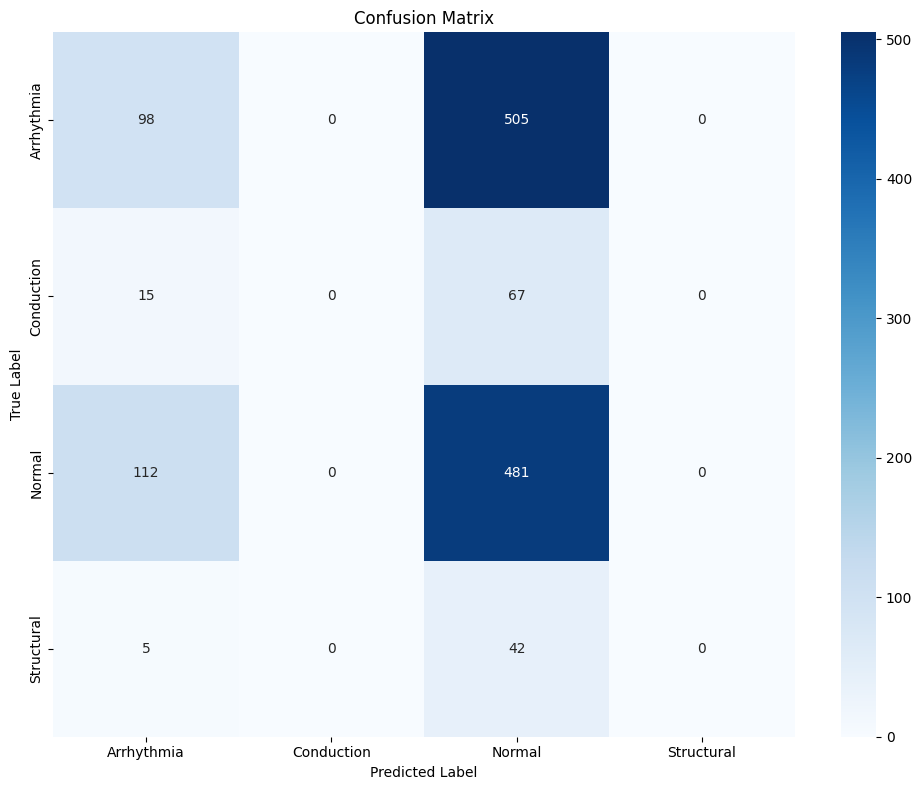

              precision    recall  f1-score   support

  Arrhythmia       0.43      0.16      0.24       603
  Conduction       0.00      0.00      0.00        82
      Normal       0.44      0.81      0.57       593
  Structural       0.00      0.00      0.00        47

    accuracy                           0.44      1325
   macro avg       0.22      0.24      0.20      1325
weighted avg       0.39      0.44      0.36      1325



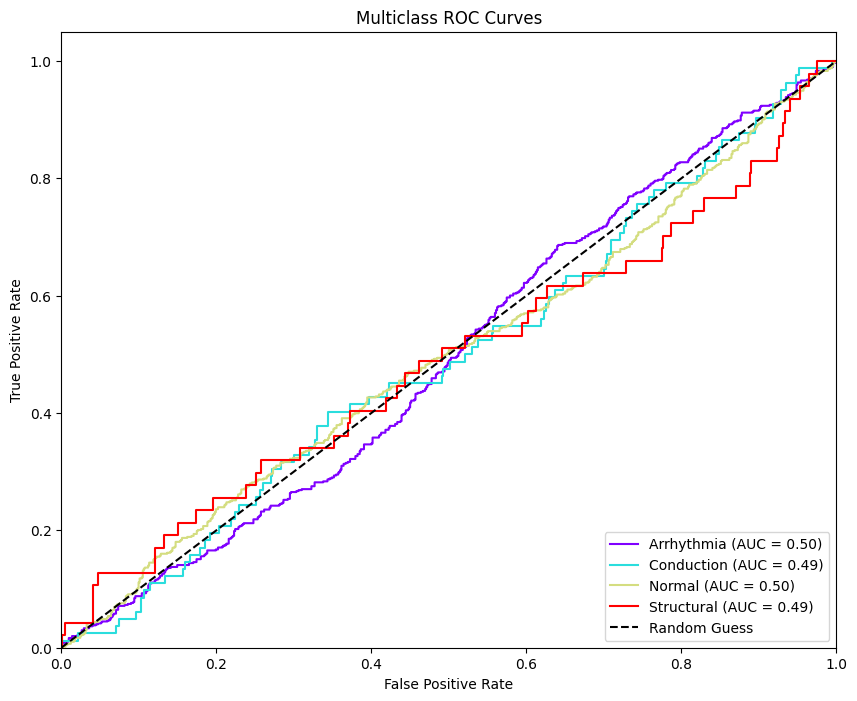

In [30]:
# Evaluate
metrics = model.evaluate(X_val, y_val)